# Agentic Workflow #3 -- Multi-Agents (Graph Workflow)

In the previous examples, we can see how agent interact with multiple tools. However, the tools are **very specific** and **not very flexible**.

A better approach is to **let the agents to automatically generate the SQL queries** and **interact with the database**. This can bring us several benefits:
- **Flexibility**: The agents can generate any SQL query they need, without being limited to a specific set of tools.
- **High-quality**: The agents can generate high-quality SQL queries, which can lead to better results.

In [ ]:
import sys

sys.path.append("..")

import nest_asyncio

nest_asyncio.apply()

from src.schema import (
    Customer,
    Order,
    OrderItem,
    Product
)
from pathlib import Path
import csv
from IPython.display import display, SVG, Markdown

API_KEY = '<enter your API key>'

## Data Import

The company has some **CSV files** regarding the `customers`, `products`, `orders` nad `order_items` tables. You have been given the following files:
- `src/assets/customers.csv`

- `src/assets/products.csv`

- `src/assets/orders.csv`

- `src/assets/order_items.csv`

In [31]:
from src.utils import init_db

BASE_ASSETS_PATH = Path("..") / "src" / "assets"

with (BASE_ASSETS_PATH / "customers.csv").open("r") as f:
    customers = [
        Customer.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "products.csv").open("r") as f:
    products = [
        Product.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "orders.csv").open("r") as f:
    orders = [
        Order.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "order_items.csv").open("r") as f:
    order_items = [
        OrderItem.model_validate(row)
        for row in csv.DictReader(f)
    ]

await init_db(
    BASE_ASSETS_PATH / "database.db",
    *customers,
    *products,
    *orders,
    *order_items
)

### Entity-Relationship Diagram (ERD)

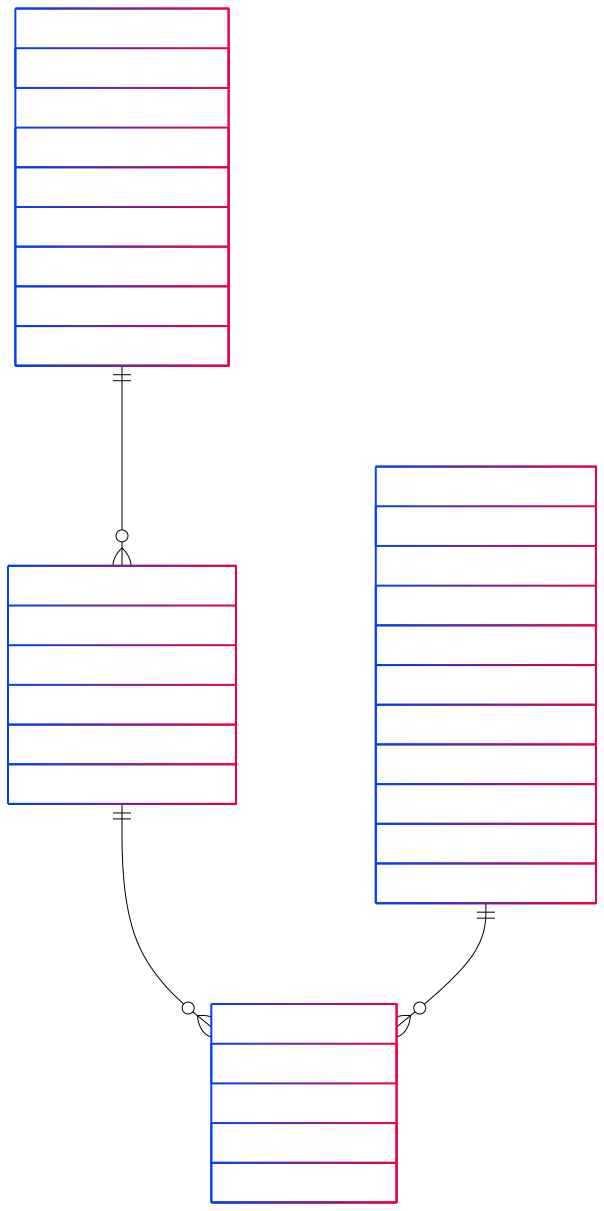

In [32]:
display(SVG(filename='pictures/er-diagram.svg'))

In [ ]:
from pydantic import BaseModel, ConfigDict
from pydantic_ai import Agent, RunContext, ModelRetry
from src.utils import session_connect
from sqlalchemy.ext.asyncio import AsyncEngine, create_async_engine
from sqlmodel import select, text
import sqlalchemy as sa
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
from pydantic_ai.messages import ModelMessage
import uuid

In [34]:
# Don't change the following!

class BusinessAnalysisDeps(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    engine: AsyncEngine
    all_tables: list[str]

async def get_all_tables_schemas(
    ctx: RunContext[BusinessAnalysisDeps]
) -> list[str]:
    """
    Get all tables schema from the database
    """
    
    async with session_connect(ctx.deps.engine) as session:
        sql = text(
            """
            SELECT sql
            FROM sqlite_schema
            WHERE type='table'
                AND tbl_name IN ({})
            """.format(
                ",".join(
                    [f":table_{i}" for i in range(len(ctx.deps.all_tables))]
                )
            )
        ).bindparams(
            **{
                f"table_{i}": table
                for i, table in enumerate(ctx.deps.all_tables)
            }
        )

        results = await session.exec(sql)
        return [
            result[0]
            for result in results.all()
        ]

async def execute_readonly_sql_command(
    ctx: RunContext[BusinessAnalysisDeps], query: str, columns: list[str] = None
) -> dict[str, list[str | bytes | int | float]]:
    """
    Execute any readonly sql command from the database
    """
    if not query.upper().strip().startswith("SELECT"):
        raise ModelRetry('Please create a SELECT query')
    
    async with session_connect(ctx.deps.engine) as session:
        sql = text(query)
        results = await session.exec(sql)
        column_names = results.keys()
        rows = results.all()
        
        table: dict[str, list[str]] = {}
        for column in column_names:
            table[column] = []
            
        for row in rows:
            for column_name, row_val in zip(column_names, row):
                table[column_name].append(row_val)
        return table
        

Here we expose 2 tools, one for getting the table schema and another one for executing the SQL queries.

Another tool `generate_sql_query` is exposed as an actor-critic agent format where the two roles (actor and critic) are separated for different tasks:
- **Actor**: Generates the SQL query based on the input question.
- **Critic**: Evaluates the generated SQL query and provides feedback to the actor.

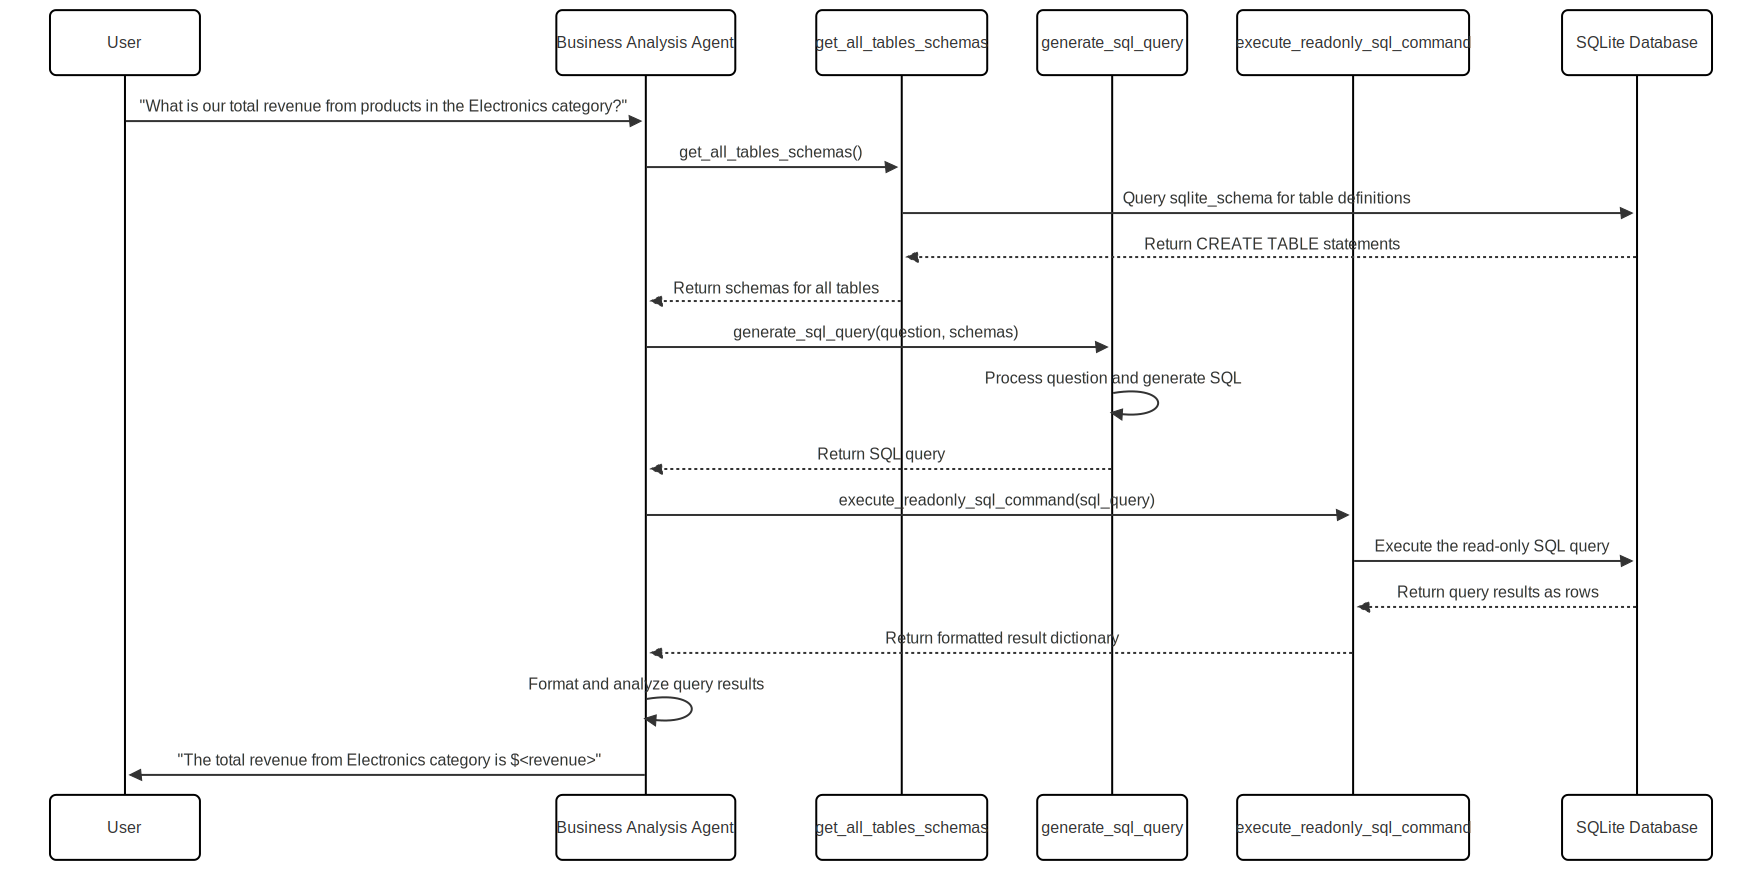

In [35]:
display(SVG(filename='pictures/agent-graph-interaction.svg'))

The actor-critic graph works as follows:

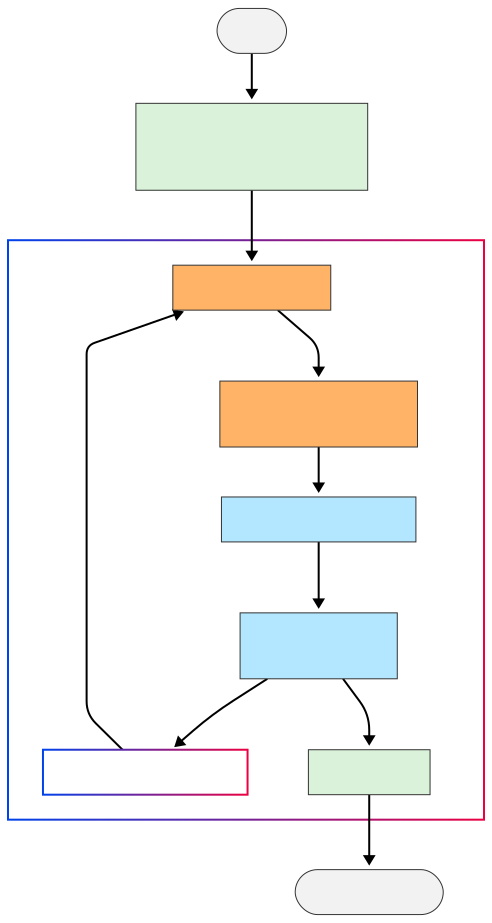

In [36]:
display(SVG(filename='pictures/actor-critic.svg'))

In [ ]:
model = OpenAIModel(
    'accounts/fireworks/models/qwq-32b',  # model library available at https://fireworks.ai/models
    provider=OpenAIProvider(
        base_url='https://api.fireworks.ai/inference/v1',
        api_key=API_KEY,
    ),
)

## Task

Based on the graph provided, you need to:
- Create a prompt to generate the SQL queries.
- Create a prompt when the SQL query is not correct (the feedback from the critic).
- Conditionally return different nodes based on the critic's feedback.

In [42]:
from dataclasses import dataclass
from typing import Optional
from pydantic import Field
from pydantic_ai import format_as_xml
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

class SQLQueryGenState(BaseModel):
    user_query: str
    sql_schemas: list[str]
    generator_agent_messages: list[ModelMessage] = Field(default_factory=list)

class GeneratedSQL(BaseModel):
    query: str

sql_generator_agent = Agent(
    model=model,
    output_type=GeneratedSQL,
    system_prompt=(
        "Generate an SQL SELECT statement based on the user's request, optional feedback "
        "from the feedback agent, and the database schemas."
    )
)

@dataclass
class SQLQueryGenNode(BaseNode[SQLQueryGenState]):
    sql_feedback: Optional[str] = None
    
    async def run(self, ctx: GraphRunContext[SQLQueryGenState]) -> "SQLQueryFeedBackNode":
        if self.sql_feedback:
            prompt = (
                "Rewrite the sql based on the user's request and the feedback provided:\n"
                f'Request: {ctx.state.user_query}\n'
                f'Schema: {format_as_xml(ctx.state.sql_schemas)}\n'
                f'Feedback: {self.sql_feedback}'
            )
        else:
            prompt = (
                "Generate an SQL SELECT statement based on the user's request:\n"
                f'Request: {ctx.state.user_query}\n'
                f'Schema: {format_as_xml(ctx.state.sql_schemas)}\n'
            )

        result = await sql_generator_agent.run(
            prompt,
            message_history=ctx.state.generator_agent_messages,
        )
        ctx.state.generator_agent_messages += result.all_messages()
        return SQLQueryFeedBackNode(result.output)

class SQLRequiresWrite(BaseModel):
    feedback: str


class SQLOk(BaseModel):
    pass

sql_feedback_agent = Agent[None, SQLRequiresWrite | SQLOk](
    model=model,
    output_type=SQLRequiresWrite | SQLOk,
    system_prompt=(
        "Review the generated sql and provide the feedback for amendment. "
        "The sql must reference the user's request and table schema "
        "to ensure the sql can be executed correctly and achieve the result "
        "the user requested."
    ),
)

@dataclass
class SQLQueryFeedBackNode(BaseNode[SQLQueryGenState, None, GeneratedSQL]):
    sql: GeneratedSQL

    async def run(
        self,
        ctx: GraphRunContext[SQLQueryGenState],
    ) -> SQLQueryGenNode | End[GeneratedSQL]:
        prompt = format_as_xml({'user_request': ctx.state.user_query, 'generated_sql': self.sql})
        result = await sql_feedback_agent.run(prompt)
        if isinstance(result.output, SQLRequiresWrite):
            return SQLQueryGenNode(sql_feedback=result.output.feedback)
        else:
            return End(self.sql)

async def generate_sql_query(ctx: RunContext[BusinessAnalysisDeps], sql_schemas: list[str]) -> str:
    state = SQLQueryGenState(
        user_query=ctx.prompt,
        sql_schemas=sql_schemas,
    )
    sql_query_gen_graph = Graph(nodes=(SQLQueryGenNode, SQLQueryFeedBackNode))
    result = await sql_query_gen_graph.run(SQLQueryGenNode(), state=state)
    return result.output

In [46]:
business_analysis_agent_3 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_all_tables_schemas,
        generate_sql_query,
        execute_readonly_sql_command,
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "Answer the questions as much as possible by guessing the context, "
        "or explore some tools you have on hand. Everytime you are answering a question, "
        "follow the observation-think-action pattern where you have to observe "
        "the existing situation, then think of the environment, and finally do some action on it. "
        "Review your action (next observation) and rethink what's the best action you can do "
        "until you can get the answer. Output the result in markdown format."
    )
)

engine = create_async_engine(
    "sqlite+aiosqlite:///../src/assets/database.db"
)

In [ ]:
# Don't change the following!

result = await business_analysis_agent_3.run(
    (
        "Get me the top 10 products sold in 2025 April, "
        "including the product name, quantity sold, and revenue amount, "
        "sorted by the revenue amount in descending order"
    ),
    deps=BusinessAnalysisDeps(
        engine=engine,
        all_tables=[Customer.__tablename__, Order.__tablename__, OrderItem.__tablename__, Product.__tablename__]
    )
)
display(Markdown(result.data))

```
Here are the top 10 products sold in April 2025, sorted by revenue:

| Product Name                 | Quantity Sold | Revenue       |
| ---------------------------- | ------------- | ------------- |
| Canon EOS R6                 | 20            | 339980        |
| Dell XPS 15 Laptop           | 15            | 238485        |
| Huawei MateBook X Pro        | 16            | 159984        |
| LG Gram 16                   | 12            | 155988        |
| Nikon Z6 II                  | 9             | 143991        |
| Samsung Galaxy S23 Ultra     | 17            | 141083        |
| MSI Gaming Laptop            | 9             | 125991        |
| Lenovo ThinkPad X1 Carbon    | 9             | 125991        |
| HP Spectre Laptop            | 9             | 125991        |
| Fujifilm X-T4                | 9             | 125991        |
```


In [48]:
async with session_connect(engine) as session:
    sql = text(
        """
        SELECT
            p.name,
            SUM(oi.quantity) AS quantity,
            SUM(oi.quantity * p.unit_price) AS revenue
        FROM
            orderitem oi
        INNER JOIN product p
            ON oi.product_id = p.id
        INNER JOIN "order" o
            ON oi.order_id = o.id
        WHERE o.order_date BETWEEN '2025-04-01' AND '2025-04-30'
        GROUP BY p.name
        ORDER BY revenue DESC
        LIMIT 10
        """
    )
    result = await session.exec(sql)
    products = result.all()
    for product, quantity, revenue in products:
        print(f"Product: {product}, Quantity: {quantity}, Revenue: {revenue}")

Product: Canon EOS R6, Quantity: 20, Revenue: 339980.0
Product: Dell XPS 15 Laptop, Quantity: 15, Revenue: 238485.0
Product: Huawei MateBook X Pro, Quantity: 16, Revenue: 159984.0
Product: LG Gram 16, Quantity: 12, Revenue: 155988.0
Product: Nikon Z6 II, Quantity: 9, Revenue: 143991.0
Product: Samsung Galaxy S23 Ultra, Quantity: 17, Revenue: 141083.0
Product: MSI Gaming Laptop, Quantity: 9, Revenue: 125991.0
Product: Lenovo ThinkPad X1 Carbon, Quantity: 9, Revenue: 125991.0
Product: HP Spectre Laptop, Quantity: 9, Revenue: 125991.0
Product: Fujifilm X-T4, Quantity: 9, Revenue: 125991.0
